<a href="https://colab.research.google.com/github/thisisdhritiman1439/ResumeParserAI/blob/main/ResumeParserAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset Loaded Successfully.
       Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...
       Category     Score  Cluster
0  Data Science  2.684633        1
1  Data Science  3.501632        1
2  Data Science  4.590968        1
3  Data Science  3.153770        1
4  Data Science  4.128457        1
5  Data Science  3.458036        1
6  Data Science  3.288867        4
7  Data Science  2.502403        1
8  Data Science  3.051241        2
9  Data Science  3.745587        4


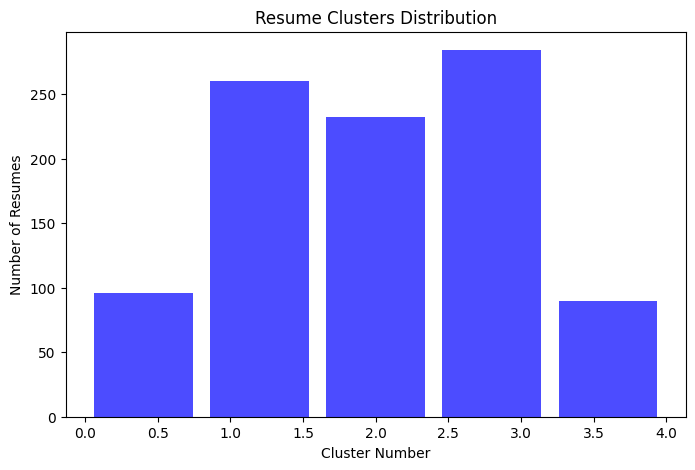


Sample Data with Scores:
        Category     Score Placement Suitable
0  Data Science  9.722473                Yes
1  Data Science  7.246007                Yes
2  Data Science  7.018635                Yes
3  Data Science  9.287194                Yes
4  Data Science  6.068970                Yes
5  Data Science  8.037881                Yes
6  Data Science  8.725731                Yes
7  Data Science  9.247435                Yes
8  Data Science  9.040478                Yes
9  Data Science  7.472720                Yes

Upload a sample resume for testing:


KeyboardInterrupt: 

In [20]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load the dataset
dataset_path = "/content/ResumeDataSet.csv"
df = pd.read_csv(dataset_path)

if 'Resume' not in df.columns or 'Category' not in df.columns:
    print("Error: Dataset must contain 'Resume' and 'Category' columns. Found:", df.columns)
else:
    print("Dataset Loaded Successfully.")

# Check data
print(df.head())

# Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = word_tokenize(text)
    words = [w for w in words if w not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]  # Lemmatization
    return ' '.join(words)

# Apply preprocessing
df['cleaned_resume'] = df['Resume'].apply(preprocess_text)

# Convert text to numerical form using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['cleaned_resume']).toarray()

# Apply KMeans clustering
num_clusters = 5  # You can change this value
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X)
df['Cluster'] = kmeans.labels_

# Assigning scores based on cluster distances
scaler = MinMaxScaler()
df['Score'] = scaler.fit_transform(kmeans.transform(X)).mean(axis=1)
df['Score'] = (1 - df['Score']) * 10  # Convert to 0-10 scale

# Display results
print(df[['Category', 'Score', 'Cluster']].head(10))

# Visualizing Cluster Distribution
plt.figure(figsize=(8, 5))
plt.hist(df['Cluster'], bins=num_clusters, color='blue', alpha=0.7, rwidth=0.85)
plt.xlabel("Cluster Number")
plt.ylabel("Number of Resumes")
plt.title("Resume Clusters Distribution")
plt.show()

# ATS Score Calculation (0-10 scale)
distances = np.linalg.norm(kmeans.transform(X) - kmeans.transform(X).min(axis=1)[:, None], axis=1)
scaler = MinMaxScaler(feature_range=(0, 10))
df['Score'] = 10 - scaler.fit_transform(distances.reshape(-1, 1)).flatten()
df['Score'] = df['Score'].clip(0, 10)

# Placement Suitability Check
df['Placement Suitable'] = df['Score'].apply(lambda x: "Yes" if x >= 5 else "No")

print("\nSample Data with Scores:\n", df[['Category', 'Score', 'Placement Suitable']].head(10))

# Function to extract top keywords from high-scoring resumes
def extract_top_keywords(cluster_num, top_n=10):
    cluster_resumes = df[df['Cluster'] == cluster_num]['cleaned_resume']
    vectorized_resumes = vectorizer.transform(cluster_resumes)
    feature_array = np.array(vectorizer.get_feature_names_out())
    tfidf_means = np.mean(vectorized_resumes.toarray(), axis=0)
    top_keywords = feature_array[np.argsort(tfidf_means)[-top_n:]]
    return list(top_keywords)

# Function to test a new resume & provide suggestions
def test_resume():
    print("\nUpload a sample resume for testing:")
    uploaded_file = files.upload()
    file_name = list(uploaded_file.keys())[0]

    resume_text = ""
    for encoding in ['utf-8', 'latin-1', 'cp1252']:
        try:
            with open(file_name, 'r', encoding=encoding) as file:
                resume_text = file.read()
            break
        except UnicodeDecodeError:
            continue

    if not resume_text:
        print("Error: Unable to read the resume file.")
        return

    cleaned_resume = preprocess_text(resume_text)
    resume_vector = vectorizer.transform([cleaned_resume]).toarray()
    predicted_cluster = kmeans.predict(resume_vector)[0]

    # Calculate ATS Score
    distance = np.linalg.norm(kmeans.transform(resume_vector) - kmeans.transform(resume_vector).min(axis=1)[:, None], axis=1)
    score = 10 - scaler.transform(distance.reshape(-1, 1)).flatten()[0]
    score = max(0, min(10, score))

    # Placement Suitability
    placement_status = "Yes" if score >= 5 else "No"

    # Extract Top Skills for this Job Title
    top_keywords = extract_top_keywords(predicted_cluster, top_n=10)

    # Suggest Missing Skills
    resume_words = set(cleaned_resume.split())
    missing_skills = [word for word in top_keywords if word not in resume_words]

    print("\n===== Resume Evaluation Result =====")
    print(f"Predicted Job Role Cluster: {predicted_cluster}")
    print(f"Resume ATS Score: {score:.2f}/10")
    print(f"Suitable for Placement: {placement_status}")
    print("\nTop Required Skills for This Role:", top_keywords)
    print("Suggested Skills to Improve:", missing_skills if missing_skills else "None")

# Run test resume function
test_resume()
